In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 8)
!date

Mon Mar 20 15:36:28 PDT 2023


# PRL V&V - Social Security Observer

In [2]:
%cd /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/vv_tax_observers/united_states_of_america/2023_03_06_12_42_55/final_results/2023_03_14_16_41_22
!ls -halt

/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/vv_tax_observers/united_states_of_america/2023_03_06_12_42_55/final_results/2023_03_14_16_41_22
total 14G
drwxrwsr-x  2 albrja IHME-Simulationscience 4.0K Mar 15 10:01 .
-rw-r--r--  1 albrja IHME-Simulationscience  59M Mar 15 10:01 wic_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 1.5G Mar 15 10:01 tax_dependents_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 6.8G Mar 15 09:57 tax_w2_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 4.1G Mar 15 09:56 tax_1040_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 192M Mar 15 09:48 social_security_observer.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience  35M Mar 15 09:36 household_survey_observer_cps.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 6.7M Mar 15 09:36 household_survey_observer_acs.csv.bz2
-rw-r--r--  1 albrja IHME-Simulationscience 638M Mar 15 09:36 decennial_census_observer.csv.bz2
drwx

In [3]:
%%time

df = pd.read_csv('social_security_observer.csv.bz2', low_memory=False, dtype='category',
                 nrows=1_000_000
                )

CPU times: user 12.8 s, sys: 586 ms, total: 13.4 s
Wall time: 13.3 s


In [4]:
df

,ssn,middle_initial,event_type,last_name,first_name,event_date,simulant_id,date_of_birth
0,786-77-6454,M,creation,Bingham,Peter,1921-05-13,2284_733465,1921-05-13
1,688-88-6377,D,creation,Bingham,Janice,1921-06-21,2284_733466,1921-06-21
2,651-33-9561,H,creation,Burdick,Anna,1921-07-13,2284_776885,1921-07-13
3,665-25-7858,M,creation,Tapia,Gertrude,1921-07-26,2284_869365,1921-07-26
...,...,...,...,...,...,...,...,...
999996,378-10-3757,C,death,Rhodes,Karen,2021-08-18,2284_499762,1948-12-10
999997,847-72-9612,S,death,Ayala-Rivera,Thomas,2021-08-18,2284_124489,1949-01-05
999998,811-81-0649,S,death,Horton,Ronald,2021-08-18,2284_165020,1949-02-14
999999,315-54-4731,M,death,Chaumont,Maureen,2021-08-18,2284_603412,1949-02-17


# VV issues

* ssn could be an int, to save space/time
* event type is categorical, could specifiy when reading csv
* (names could also be treated as categorical)
* event_date might be better clipped to some date when SS started (somebody reading this data will realize that there was no SSA in 1921!)
* simulant_id could be an int (or float)
* a single simulant_id shouldn't have multiple SSNs
* age distributions (event_date and date_of_birth; death event should always be after creation event for one simulant_id; mostly older simulants with event_type == death; creation events should have event_date == date_of_birth)
* No columns denoting place of origin: how do we know which simulants are foreign-born? Should we link to a different observer that does include whether a sim is foreign-born or not? Or is this something SWEs are automatically testing for?


In [5]:
df.ssn.value_counts()  # expect 1 and 2 values here

145-31-9773    2
103-44-8046    2
690-33-7017    2
690-33-3444    2
              ..
302-89-9818    1
302-89-9978    1
302-90-3782    1
899-99-9854    1
Name: ssn, Length: 987886, dtype: int64

In [6]:
ssn_occurrences = df.ssn.value_counts()
assert set(ssn_occurrences.unique()) == set([1,2]), 'expect each ssn to appear once or twice'

In [7]:
df.middle_initial.nunique()  # expect 26

26

In [8]:
assert df.middle_initial.nunique()  == 26, 'expect all 26 letters to appear as a middle initial for somebody'

In [9]:
df.iloc[0].to_dict()

{'ssn': '786-77-6454',
 'middle_initial': 'M',
 'event_type': 'creation',
 'last_name': 'Bingham',
 'first_name': 'Peter',
 'event_date': '1921-05-13',
 'simulant_id': '2284_733465',
 'date_of_birth': '1921-05-13'}

In [10]:
df['dob'] = pd.to_datetime(df.date_of_birth)

In [11]:
df['year_of_birth'] = df.dob.dt.year

<AxesSubplot:>

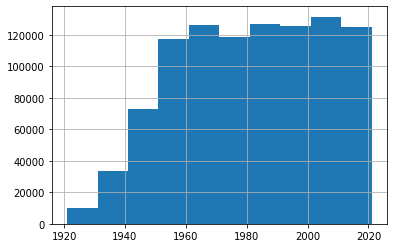

In [12]:
df[df.event_type == 'creation'].year_of_birth.hist()

<AxesSubplot:>

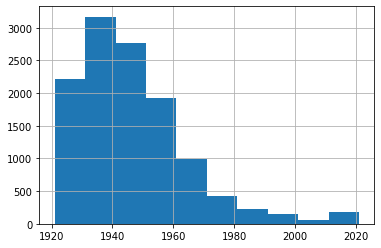

In [13]:
df[df.event_type == 'death'].year_of_birth.hist()

In [14]:
df.first_name.value_counts()

Michael     14213
John        12734
James       12461
Robert      11623
            ...  
Cutler          1
Rosamond        1
Madalin         1
Hayk            1
Name: first_name, Length: 11788, dtype: int64

[]

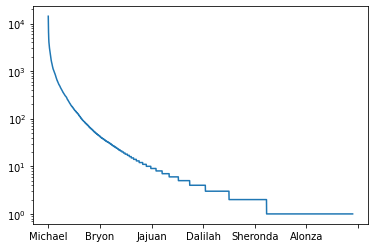

In [15]:
df.first_name.value_counts().plot()
plt.semilogy()

In [16]:
df.event_date = pd.to_datetime(df.event_date)

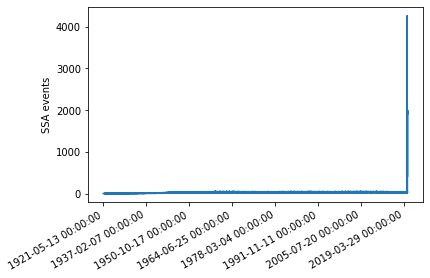

In [17]:
df.event_date.value_counts().sort_index().plot()
plt.ylabel('SSA events');

In [19]:
df.event_date.value_counts()

2020-03-04 00:00:00    4270
2020-07-22 00:00:00    2001
2020-05-27 00:00:00    1993
2021-07-21 00:00:00    1989
                       ... 
1923-01-03 00:00:00       1
1922-12-31 00:00:00       1
1923-12-19 00:00:00       1
1921-05-13 00:00:00       1
Name: event_date, Length: 35389, dtype: int64

In [20]:
max_day = df.event_date.value_counts().index[0]

df[df.event_date == max_day]

,ssn,middle_initial,event_type,last_name,first_name,event_date,simulant_id,date_of_birth,dob,year_of_birth
961235,891-23-3325,L,creation,Luchin,Maurice,2020-03-04,2284_248,2020-03-04,2020-03-04,2020
961236,766-69-0018,A,creation,Harris,Darian,2020-03-04,2284_925,2020-03-04,2020-03-04,2020
961237,334-50-2250,C,creation,Pestana,Javier,2020-03-04,2284_986,2020-03-04,2020-03-04,2020
961238,616-18-2931,M,creation,Hamilton,Mila,2020-03-04,2284_1233,2020-03-04,2020-03-04,2020
...,...,...,...,...,...,...,...,...,...,...
965501,864-19-2082,M,creation,Lewis,Mila,2020-03-04,2284_968972,2020-03-04,2020-03-04,2020
965502,277-48-4523,S,creation,Roberts,Jaliyah,2020-03-04,2284_969275,2020-03-04,2020-03-04,2020
965503,736-62-3154,L,creation,Thompson,Arya,2020-03-04,2284_969329,2020-03-04,2020-03-04,2020
965504,466-10-2218,J,creation,Abston,Emilia,2020-03-04,2284_969736,2020-03-04,2020-03-04,2020


In [21]:
second_to_max_day = df.event_date.value_counts().index[1]

df[df.event_date == second_to_max_day]

,ssn,middle_initial,event_type,last_name,first_name,event_date,simulant_id,date_of_birth,dob,year_of_birth
972274,318-16-7924,P,death,Fitch,Amelia,2020-07-22,2284_508944,1923-05-18,1923-05-18,1923
972275,514-08-8114,D,death,Sommer,Susie,2020-07-22,2284_471801,1923-06-06,1923-06-06,1923
972276,221-67-7051,G,death,Conroy,Rita,2020-07-22,2284_705740,1923-06-19,1923-06-19,1923
972277,684-47-3570,J,death,Stephens,Ross,2020-07-22,2284_785602,1923-08-19,1923-08-19,1923
...,...,...,...,...,...,...,...,...,...,...
974271,734-04-8562,A,creation,Ward,Wren,2020-07-22,2284_1006176,2020-08-18,2020-08-18,2020
974272,167-11-9504,C,creation,Minarik,Theodore,2020-07-22,2284_1006209,2020-08-18,2020-08-18,2020
974273,485-89-9645,R,creation,Flanagan,Ryder,2020-07-22,2284_1006268,2020-08-18,2020-08-18,2020
974274,291-16-4229,A,creation,Mata,Kenai,2020-07-22,2284_1006315,2020-08-18,2020-08-18,2020
